In [11]:
!git clone https://github.com/fdsig/image_utils
# moves image getter (ava data) into working directory
!mv image_utils/image_getter.py ./image_getter.py

fatal: destination path 'image_utils' already exists and is not an empty directory.
mv: cannot stat 'image_utils/image_getter.py': No such file or directory


In [12]:
!pip install google

In [13]:
import json 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from google_drive_downloader import GoogleDriveDownloader as gdd



In [14]:
class From_Drive():
    def __init__(self,**kwargs):
        self.urls = [ ]
        fids = [fid.path for fid  in os.scandir() if 'txt' in fid.name]
        for fid in fids:
            with open(fid,'r') as txt_fid:
                self.urls = txt_fid.readlines()
                    
        self.file_keys = [url.split('/')[5] for url in self.urls]
    def google_getter(self):
        
            for f_key in self.file_keys:
                gdd.download_file_from_google_drive(file_id=f_key,
                                                        dest_path='/metrics',
                                                    unzip=False)
            files = [file.path for file in os.scandir()]
            for file in files:
                print(f'\n The files are : {file}')


In [15]:
def flatten(fid_):
    with open(fid_, 'r') as fid:
        results_dict = json.load(fid)
    keys = list(results_dict.keys())
    results_arrays_dict = { }
    for phase in ['validation', 'training']:
        results = np.stack([[results_dict[key][phase+' loss'], 
        results_dict[key][phase+' acc'], 
        results_dict[key][phase+' ballance_acc']] for key in keys if phase in key], axis=0)
        results_arrays_dict[phase]= {'loss':results[...,0], 
                                     'acc':results[...,1], 
                                     'ballanced_acc':results[...,2]}
    return results_arrays_dict

metrics = {fid_.name:flatten(fid_) for fid_ in os.scandir('metrics')}


In [16]:
def net_plot(all_metrics, epo):
    plt.rcParams['figure.figsize'] = [8,5]
    plt.rcParams['figure.dpi'] = 200
    plt.tight_layout()
    
    phases, metrics_type = ['validation', 'training'], ['acc','loss', 'ballanced_acc']
    combinations = [[i,j] for i in phases for j in metrics_type]
    print(combinations)
    dim = np.floor_divide(len(all_metrics),2)
    fig, ax = plt.subplots(dim,dim,figsize=(30,20))
    fig.patch.set_facecolor('xkcd:white')
    for idx,metrics_key in enumerate(all_metrics):
        history = all_metrics[metrics_key]
        if idx<2:
            row = 0
        else:
            row = 1
            idx -=2
        for i in combinations:
           
            ax[row,idx].plot(history[i[0]][i[1]][:10])
            ax[row,idx].grid(which='both')
            ax[row,idx].grid(which='minor',alpha=0.3)
            ax[row,idx].grid(which='major',alpha=0.9)
            ax[row,idx].set_yticks(np.linspace(0,max(history['validation']['loss']),10))
            ax[row,idx].set_xticks(np.linspace(0,len(history[i[0]][i[1]][:10]),11))
            ax[row,idx].set_ylabel('Accuracy/Loss', fontsize=12)
            ax[row,idx].set_xlabel('Epoch', fontsize=12)
            ax[row,idx].legend(combinations,loc=(1))
            ax[row,idx].set_title(metrics_key, fontsize=20)


[['validation', 'acc'], ['validation', 'loss'], ['validation', 'ballanced_acc'], ['training', 'acc'], ['training', 'loss'], ['training', 'ballanced_acc']]


<Figure size 1600x1000 with 0 Axes>

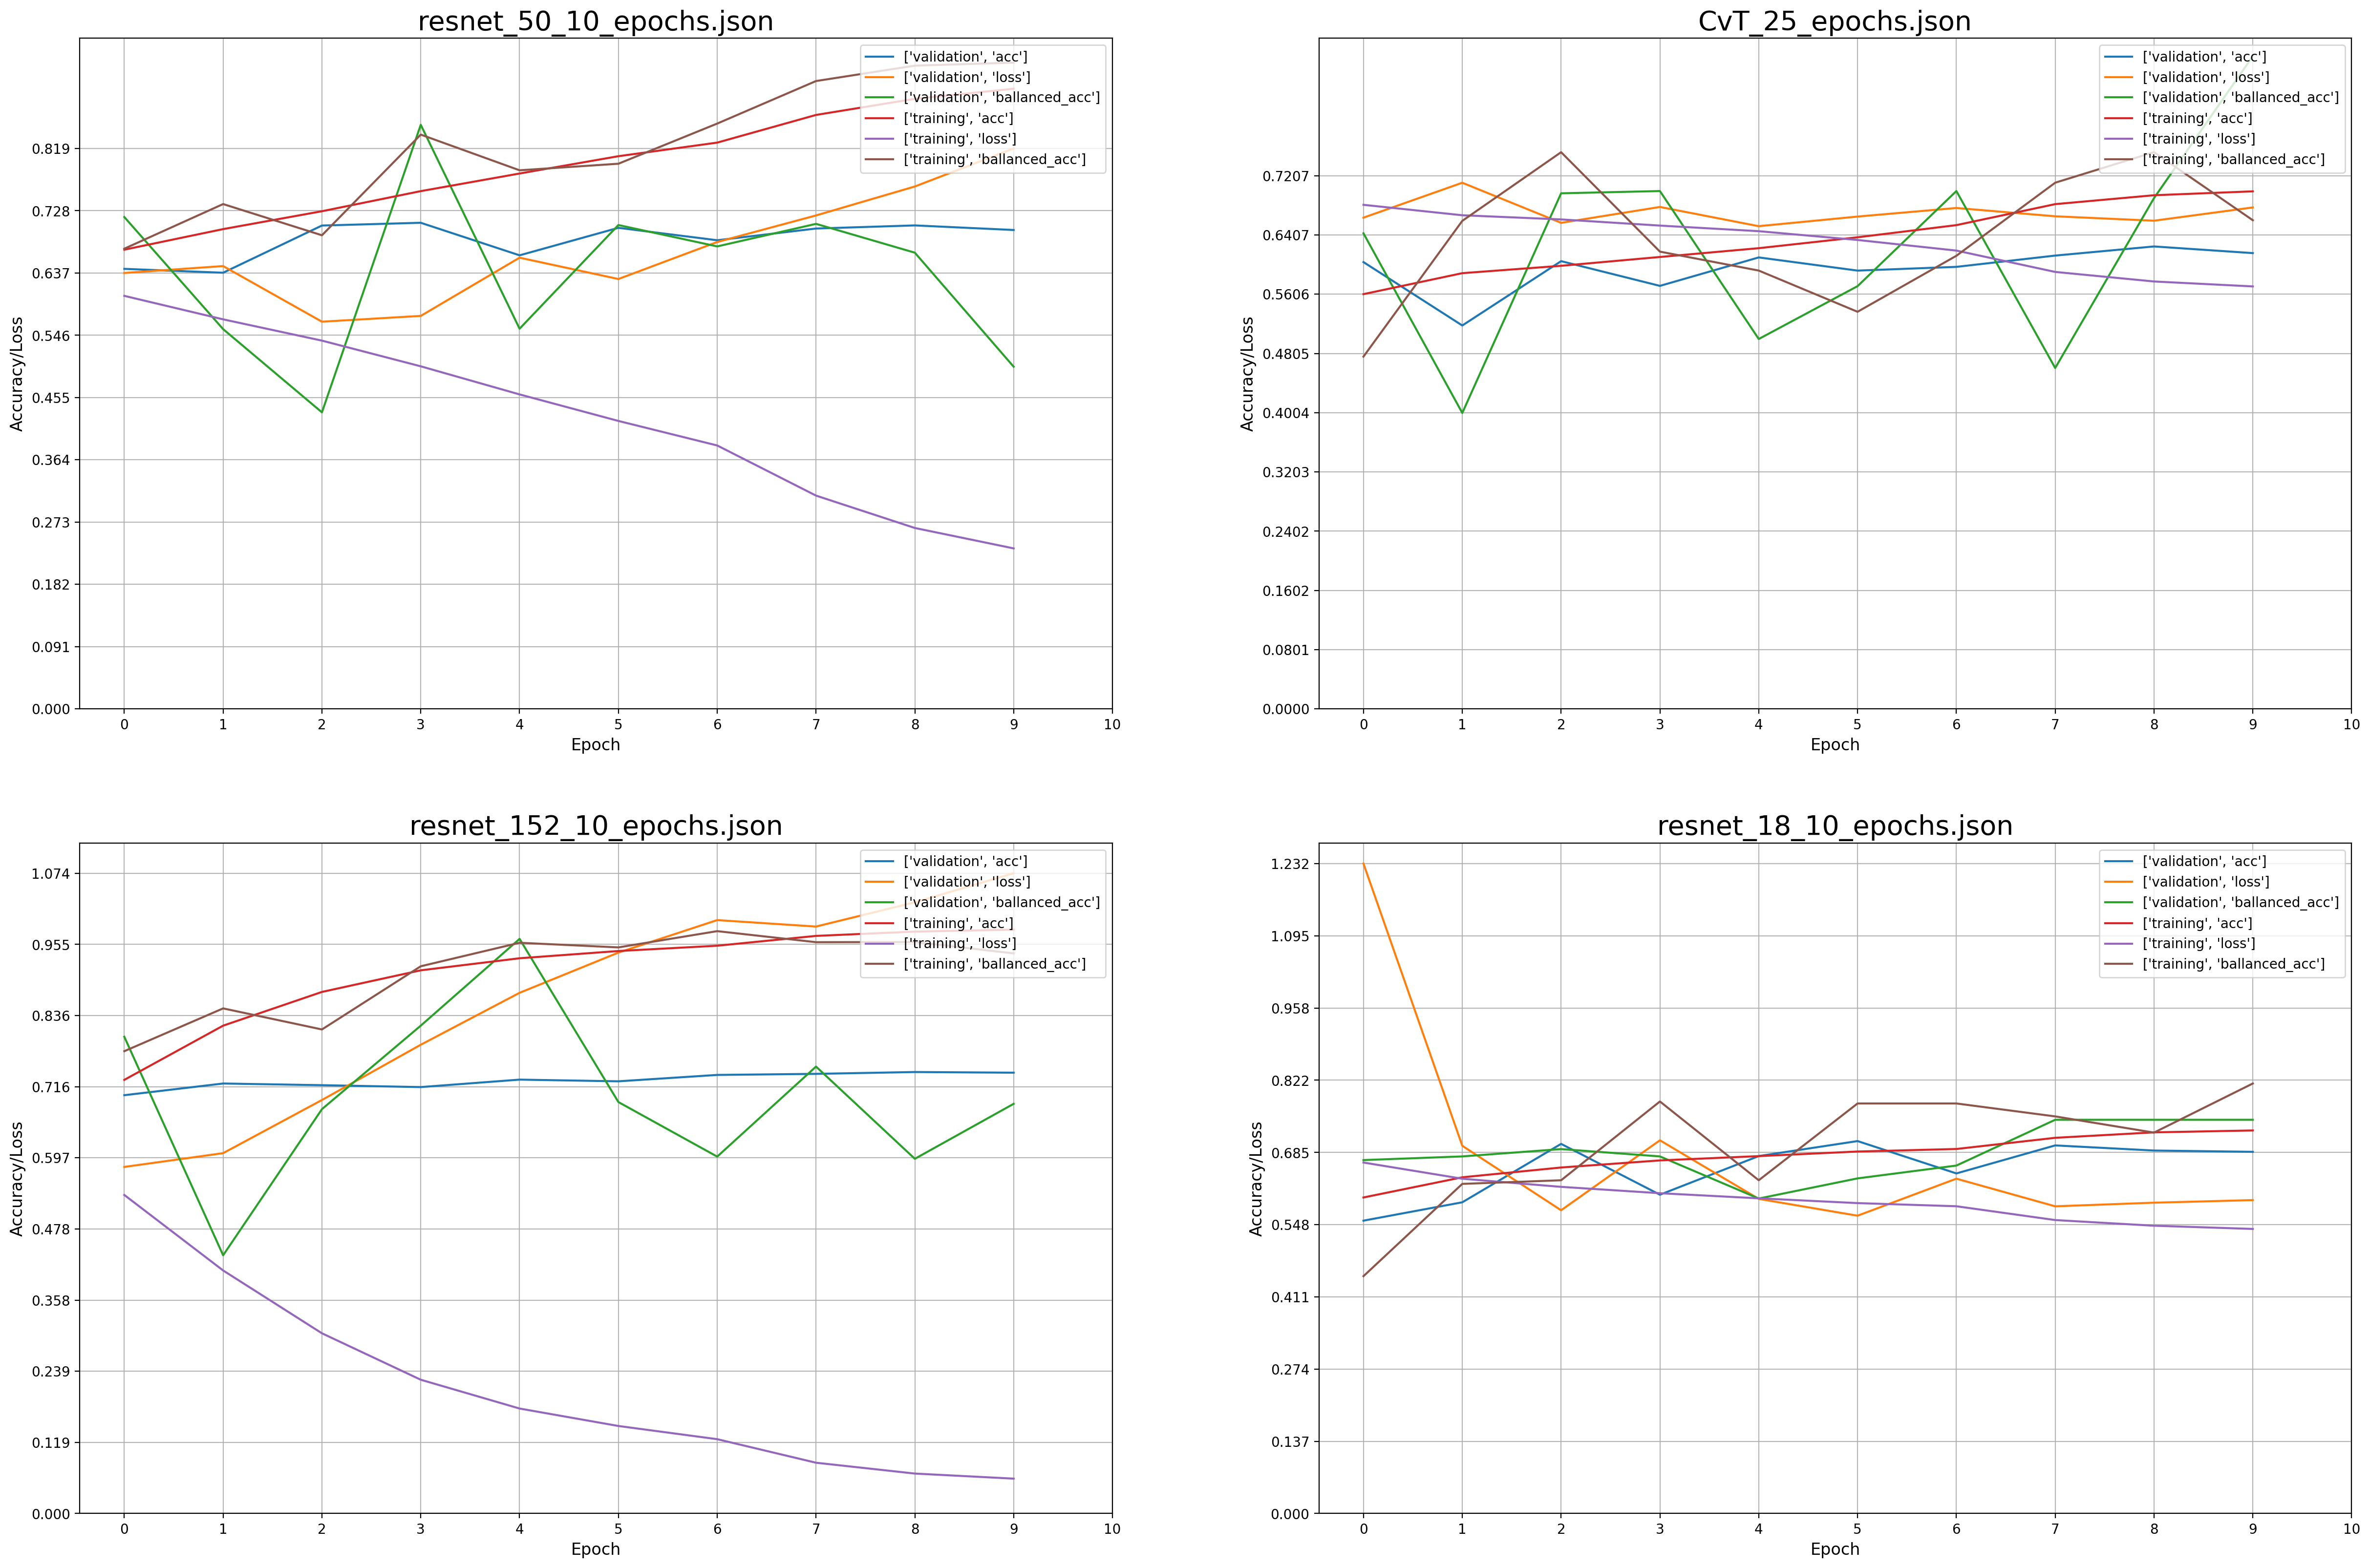

In [17]:
metrics = {i:metrics[i] for i in metrics if 'CvT_10' not in i}
net_plot(metrics, 10)

In [18]:
metrics

{'resnet_50_10_epochs.json': {'validation': {'loss': array([0.6370359 , 0.64709416, 0.56581213, 0.57426143, 0.65934666,
          0.62818765, 0.68225292, 0.72108472, 0.76338538, 0.81900953]),
   'acc': array([0.64301628, 0.63736075, 0.70634105, 0.71036847, 0.66281063,
          0.70299914, 0.6848329 , 0.70197087, 0.70651243, 0.69982862]),
   'ballanced_acc': array([0.71875   , 0.55494505, 0.43333333, 0.85353535, 0.55555556,
          0.70707071, 0.67582418, 0.70879121, 0.66666667, 0.5       ])},
  'training': {'loss': array([0.60355732, 0.56923666, 0.53813653, 0.50059599, 0.45953565,
          0.42076719, 0.3849138 , 0.31164742, 0.26433288, 0.23451941]),
   'acc': array([0.67103844, 0.70112204, 0.72723992, 0.75661519, 0.78236311,
          0.80765084, 0.82751558, 0.8679579 , 0.89153572, 0.90625268]),
   'ballanced_acc': array([0.6725    , 0.7377193 , 0.69210526, 0.83922559, 0.78706897,
          0.79666667, 0.85535117, 0.91750842, 0.94      , 0.94444444])}},
 'CvT_25_epochs.json': {'va

<Figure size 1600x1000 with 0 Axes>

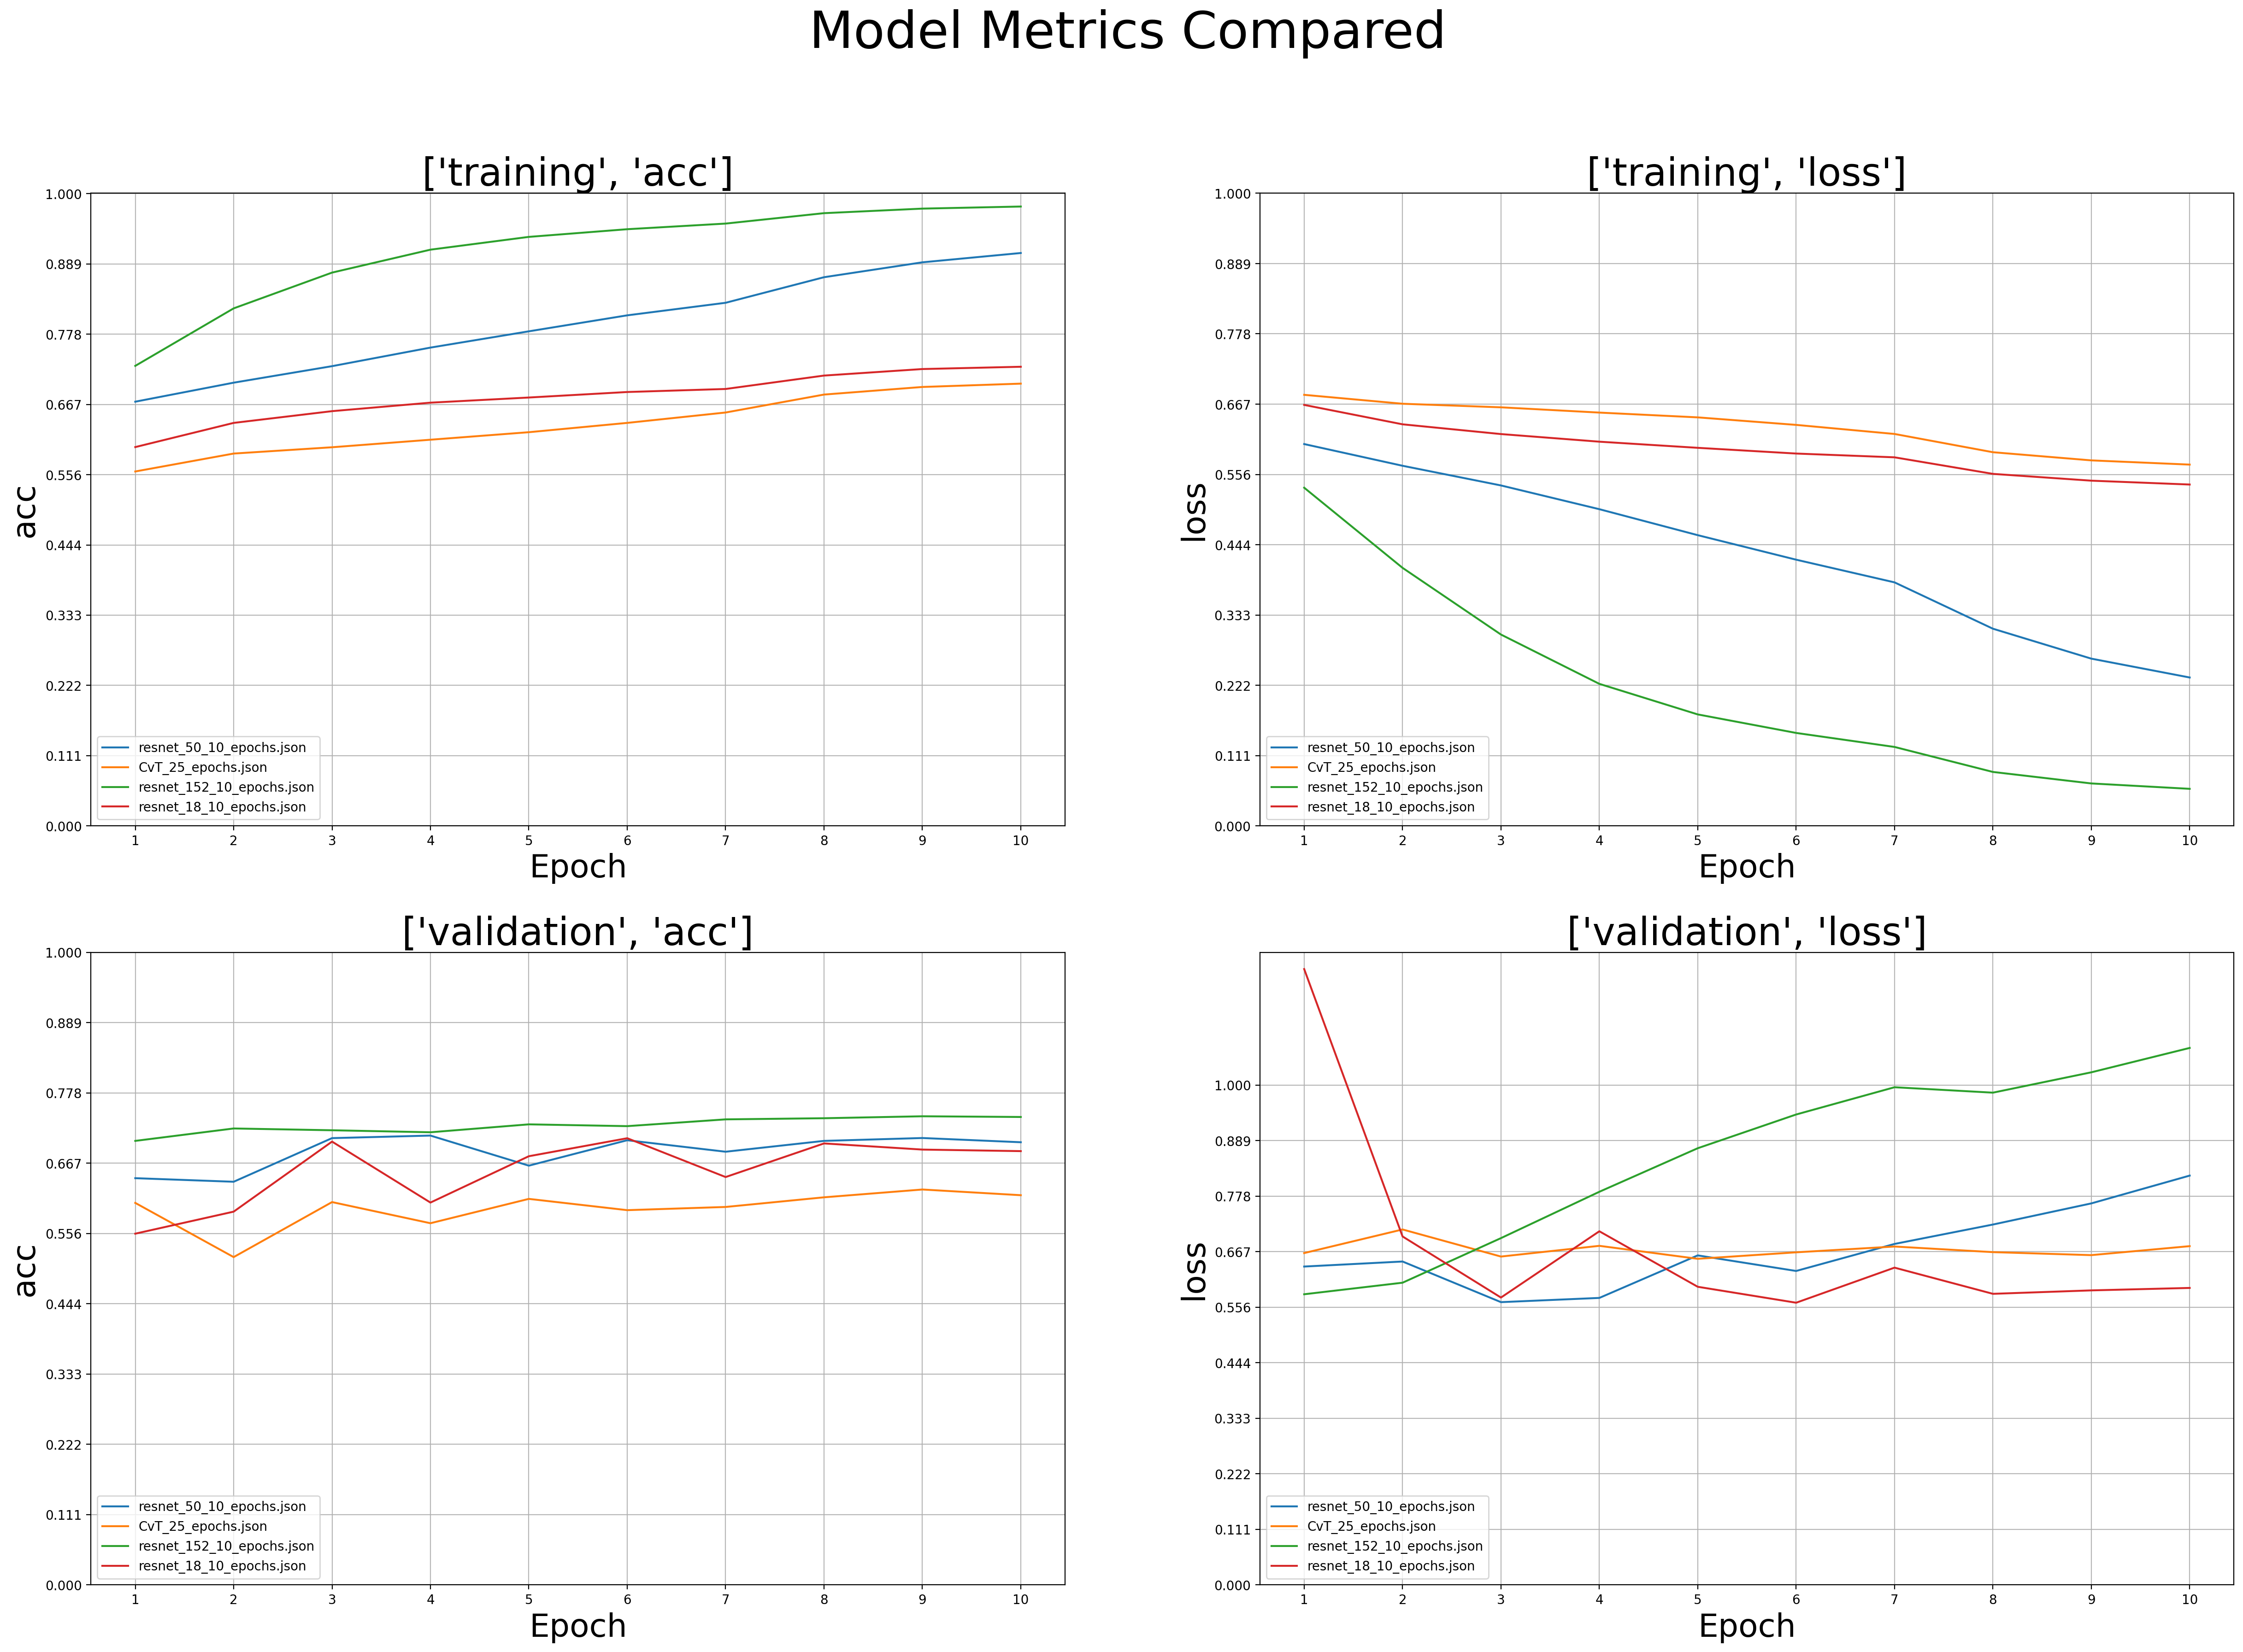

In [19]:
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['figure.dpi'] = 200
plt.tight_layout()
dim = 2
fig, ax = plt.subplots(dim,dim,figsize=(30,20))
fig.patch.set_facecolor('xkcd:white')
coords = [[i,j] for i in range(dim) for j in range(dim)]
metric_types = [[i,j]for i in ['training','validation'] for j in ['acc', 'loss']]
legend = list(metrics.keys())
for idx,key in enumerate(metrics):
    metric = metric_types[idx]
    coord = coords[idx]
    by_model = {i:metrics[i][metric[0]][metric[1]][:10] for i in metrics}
    for i in by_model:
        ax[coord[0],coord[1]].plot(range(1,11),by_model[i])
        ax[coord[0],coord[1]].grid(which='both')
        ax[coord[0],coord[1]].grid(which='minor',alpha=0.3)
        ax[coord[0],coord[1]].grid(which='major',alpha=0.9)
        ax[coord[0],coord[1]].set_yticks(np.linspace(0,1,10))
        ax[coord[0],coord[1]].set_xticks(np.linspace(1,10,10))
        ax[coord[0],coord[1]].set_ylabel(metric[1], fontsize=25)
        ax[coord[0],coord[1]].set_xlabel('Epoch', fontsize=25)
        ax[coord[0],coord[1]].legend(legend,loc=(3))
        ax[coord[0],coord[1]].set_title(metric, fontsize=30)
    fig.suptitle('Model Metrics Compared', fontsize=40)


In [20]:
{key:np.round(metrics[key]['validation']['acc'][metrics[key]['validation']['acc'].argmax()],3)
 for key in metrics}

{'resnet_50_10_epochs.json': 0.71,
 'CvT_25_epochs.json': 0.625,
 'resnet_152_10_epochs.json': 0.741,
 'resnet_18_10_epochs.json': 0.706}

In [21]:
with open('splits.json','r') as fid:
    splits = json.load(fid)
test_train_eval = np.array([[i] for i in splits.keys()])
split = np.array([list(splits[i].keys()) for i in splits])
print(np.concatenate((test_train_eval,split),axis=1))
n_classes = np.array([[str(i)+' '+str(j),len(splits[i][j])] 
                      for i in splits 
                      for j in splits[i]])
print(n_classes)


FileNotFoundError: [Errno 2] No such file or directory: 'splits.json'

In [22]:
for split in splits:
    for class_ in splits[split]:
        for splits[split][]

SyntaxError: invalid syntax (840466064.py, line 3)

In [23]:
def dict_root(dict_):
    print(len(dict_))
    for key in dict_:
        print(key)
        di = dict_[key]
        if type(di)==(dict):
            return 
        dict_root(di)

    

In [ ]:
for split in splits:
    for class_ in splits[split]:
        subset = split+'_'+class_
        to_write = {subset:[cls_ for cls_ in splits[split][class_]]}
        print(type(to_write))
        with open(subset+'.json','w') as fid:
            json.dump(to_write,fid)
        for i in to_write:
            for jpg in to_write[i]:
                with open(subset+'.txt','a') as fid:
                    fid.writelines(jpg+'\n')

In [10]:
for i in os.scandir():
    if 'json' in i.name:
        json.load(i.path)

In [98]:
i


['love', 'ad', 'infinitum', [...]] ['love', 'ad', 'infinitum', [...]]
